In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/asteroid-dataset/dataset.csv


## **Introduction**

**Problem**

Asteroids near Earth’s orbit can pose significant risks, with some classified as Potentially Hazardous Asteroids (PHAs) due to their size, proximity, and potential for impact. Accurate identification of PHAs is essential for planetary defense, enabling agencies like NASA to prioritize monitoring and mitigation efforts. Manual analysis of vast asteroid datasets is impractical, making machine learning a powerful tool to predict hazard status efficiently.

**Objective**

This project aims to develop a classification model to predict whether an asteroid is potentially hazardous (pha) based on its features, such as orbital parameters (e.g., e, a, q, i), size (diameter), and brightness (H). By exploring the data, preprocessing it, and evaluating multiple models, we’ll deliver a robust solution for asteroid hazard prediction, enhancing a data science portfolio with a real-world application.

**Approach**

Using the provided asteroid dataset, we will:

1. Conduct Exploratory Data Analysis (EDA) to understand feature distributions, missing values, and relationships with pha.
2. Preprocess the data by handling missing values, encoding categorical features, and scaling numerical ones.
3. Train classification models (e.g., Logistic Regression, Random Forest, XGBoost) to predict pha.
4. Evaluate models with metrics like accuracy, precision, recall, and F1-score, addressing potential class imbalance.
5. Visualize results and interpret findings for practical use.

This is an ideal project to demonstrate end-to-end machine learning skills from data wrangling, feature engineering, modeling, and to evaluation, applied to a high-stakes astronomical problem. Any suggestions for improvement and learning are welcome.

## **Step 1. Importing Libraries**

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

## **Step 2. Loading and Cleaning Data**

In [10]:
# load the data
df = pd.read_csv('/kaggle/input/asteroid-dataset/dataset.csv')
df.head()

,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.40,939.400,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.20,545.000,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.33,246.596,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.00,525.400,...,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.90,106.699,...,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


In [8]:
# view number of rows and columns
df.shape

(958524, 45)

In [3]:
# check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958524 entries, 0 to 958523
Data columns (total 45 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              958524 non-null  object 
 1   spkid           958524 non-null  int64  
 2   full_name       958524 non-null  object 
 3   pdes            958524 non-null  object 
 4   name            22064 non-null   object 
 5   prefix          18 non-null      object 
 6   neo             958520 non-null  object 
 7   pha             938603 non-null  object 
 8   H               952261 non-null  float64
 9   diameter        136209 non-null  float64
 10  albedo          135103 non-null  float64
 11  diameter_sigma  136081 non-null  float64
 12  orbit_id        958524 non-null  object 
 13  epoch           958524 non-null  float64
 14  epoch_mjd       958524 non-null  int64  
 15  epoch_cal       958524 non-null  float64
 16  equinox         958524 non-null  object 
 17  e         

In [4]:
# confirm null values
df.isnull().sum()

id                     0
spkid                  0
full_name              0
pdes                   0
name              936460
prefix            958506
neo                    4
pha                19921
H                   6263
diameter          822315
albedo            823421
diameter_sigma    822443
orbit_id               0
epoch                  0
epoch_mjd              0
epoch_cal              0
equinox                0
e                      0
a                      0
q                      0
i                      0
om                     0
w                      0
ma                     1
ad                     4
n                      0
tp                     0
tp_cal                 0
per                    4
per_y                  1
moid               19921
moid_ld              127
sigma_e            19922
sigma_a            19922
sigma_q            19922
sigma_i            19922
sigma_om           19922
sigma_w            19922
sigma_ma           19922
sigma_ad           19926


In [5]:
# check for duplicates
df.duplicated().sum()

0

In [7]:
# check summary statistics
df.describe()

,spkid,H,diameter,albedo,diameter_sigma,epoch,epoch_mjd,epoch_cal,e,a,...,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,rms
count,9.585240e+05,952261.000000,136209.000000,135103.000000,136081.000000,9.585240e+05,958524.000000,9.585240e+05,958524.000000,958524.000000,...,9.386020e+05,9.386020e+05,9.386020e+05,9.386020e+05,9.386020e+05,9.385980e+05,9.386020e+05,9.386020e+05,9.385980e+05,958522.000000
mean,3.810114e+06,16.906411,5.506429,0.130627,0.479184,2.458869e+06,58868.781950,2.019693e+07,0.156116,2.902143,...,1.982929e+01,1.168449e+00,5.310234e+00,1.370062e+06,1.369977e+06,2.131453e+01,5.060221e-02,4.312780e+08,8.525815e+04,0.561153
std,6.831541e+06,1.790405,9.425164,0.110323,0.782895,7.016716e+02,701.671573,1.930354e+04,0.092643,39.719503,...,2.903785e+03,1.282231e+02,1.333381e+03,9.158996e+08,9.158991e+08,7.197034e+03,9.814953e+00,2.953046e+11,2.767681e+07,2.745700
min,2.000001e+06,-1.100000,0.002500,0.001000,0.000500,2.425052e+06,25051.000000,1.927062e+07,0.000000,-14702.447872,...,1.956900e-11,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,0.000000
25%,2.239632e+06,16.100000,2.780000,0.053000,0.180000,2.459000e+06,59000.000000,2.020053e+07,0.092193,2.387835,...,1.462000e-07,6.095900e-06,3.619400e-05,5.755000e-05,2.573700e-05,2.340900e-08,2.768800e-09,1.110900e-04,1.794500e-05,0.518040
50%,2.479262e+06,16.900000,3.972000,0.079000,0.332000,2.459000e+06,59000.000000,2.020053e+07,0.145002,2.646969,...,2.271900e-07,8.688800e-06,6.642550e-05,1.047100e-04,4.900100e-05,4.359000e-08,4.638000e-09,2.230800e-04,3.501700e-05,0.566280
75%,3.752518e+06,17.714000,5.765000,0.190000,0.620000,2.459000e+06,59000.000000,2.020053e+07,0.200650,3.001932,...,6.583200e-07,1.591500e-05,1.609775e-04,3.114400e-04,1.718900e-04,1.196600e-07,1.124000e-08,8.139600e-04,9.775475e-05,0.613927
max,5.401723e+07,33.200000,939.400000,1.000000,140.000000,2.459000e+06,59000.000000,2.020053e+07,1.855356,33488.895955,...,1.015000e+06,5.533000e+04,1.199100e+06,8.845100e+11,8.845100e+11,5.509700e+06,7.698800e+03,2.853100e+14,1.910700e+10,2686.600000


#### **Dataset Summary**
The asteroid dataset contains 958,524 rows and 45 columns, detailing asteroid properties:

- **Shape:** (958,524, 45) – A large dataset with many features.
- **Target:** pha (Potentially Hazardous Asteroid flag, object type, missing in 19,921 rows) – Our binary classification target (Y/N).
- **Key Features:**
    - **Numerical:** H (absolute magnitude, 952,261 non-null), diameter (136,209 non-null), albedo (135,103 non-null), e (eccentricity), a (semi-major axis), q (perihelion distance), i (inclination), moid (Earth MOID, 938,603 non-null), and various uncertainty measures (sigma_*).
    - **Categorical:** neo (Near-Earth Object flag, 958,520 non-null), class (orbit class), orbit_id, equinox.
    - **Identifiers:** id, spkid, full_name, pdes, name (only 22,064 non-null), prefix (18 non-null).
- **Missing Values:** Significant gaps in diameter (822,315 missing), albedo (823,421 missing), name (936,460 missing), and prefix (958,506 missing); moderate gaps in pha, moid, and sigma_* (~19,921–19,926 missing); minor gaps in others (e.g., H: 6,263 missing).
- **Summary Stats:** Wide ranges (e.g., diameter: 0.0025–939.4 km, H: -1.1–33.2, e: 0–1.86), with some outliers (e.g., max sigma_w: 8.85e11).

The dataset’s size and feature richness offer ample data for modeling, but missing values (especially in diameter and albedo) and potential class imbalance in pha will require careful preprocessing.

#### **Handling Missing Values**

Since there are quite a number of missing values, let us address this problem before we can visualize the results. We will achieve this by:
1. Dropping rows where the target ('pha') is missing since it's important for our model and this is a large dataset
2. We will drop irrelevant or columns with high numbers of missing values
3. We will also impute key numerical features with the medial
4. We will also impute key categorical features with the mode

In [11]:
# Initial shape
print("Original Shape:", df.shape)

Original Shape: (958524, 45)


In [12]:
# Drop rows where target 'pha' is missing
df_clean = df.dropna(subset=['pha'])
print("Shape after dropping rows with missing 'pha':", df_clean.shape)

Shape after dropping rows with missing 'pha': (938603, 45)


In [13]:
# Drop irrelevant or high-missingness columns
drop_cols = ['id', 'spkid', 'full_name', 'pdes', 'name', 'prefix', 'orbit_id', 'epoch_cal', 'equinox', 'tp_cal']
# Note: Keeping 'epoch', 'epoch_mjd', and uncertainty cols ('sigma_*') for now; may drop later if not useful
df_clean = df_clean.drop(columns=drop_cols)
print("Shape after dropping columns:", df_clean.shape)

Shape after dropping columns: (938603, 35)


In [14]:
# Define key numerical and categorical columns to keep
numerical_cols = ['H', 'diameter', 'e', 'a', 'q', 'i', 'moid', 'epoch', 'epoch_mjd', 'albedo', 'diameter_sigma',
                  'om', 'w', 'ma', 'ad', 'n', 'tp', 'per', 'per_y', 'moid_ld', 'sigma_e', 'sigma_a', 'sigma_q',
                  'sigma_i', 'sigma_om', 'sigma_w', 'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per', 'rms']
categorical_cols = ['neo', 'class']

In [15]:
# Impute missing values
# Numerical: Median imputation
for col in numerical_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Categorical: Mode imputation
for col in categorical_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

In [16]:
# Check remaining missing values
print("\nMissing Values After Imputation:")
print(df_clean.isnull().sum())
print("\nCleaned Dataset Shape:", df_clean.shape)
print("\nCleaned Dataset Info:")
print(df_clean.info())


Missing Values After Imputation:
neo               0
pha               0
H                 0
diameter          0
albedo            0
diameter_sigma    0
epoch             0
epoch_mjd         0
e                 0
a                 0
q                 0
i                 0
om                0
w                 0
ma                0
ad                0
n                 0
tp                0
per               0
per_y             0
moid              0
moid_ld           0
sigma_e           0
sigma_a           0
sigma_q           0
sigma_i           0
sigma_om          0
sigma_w           0
sigma_ma          0
sigma_ad          0
sigma_n           0
sigma_tp          0
sigma_per         0
class             0
rms               0
dtype: int64

Cleaned Dataset Shape: (938603, 35)

Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 938603 entries, 0 to 958523
Data columns (total 35 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   ---

#### **Analysis of Results**
We have successfully cleaned the asteroid dataset and prepared it for exploratory analysis in the following ways:

1. **Shape Changes:**
    - **Original Shape:** (958,524, 45) – 958,524 rows, 45 columns.
    - **After Dropping pha Missing Rows:** (938,603, 45) – Lost 19,921 rows (2.08%), aligning with the number of missing pha values.
    - **After Dropping Columns:** (938,603, 35) – Reduced to 35 columns by dropping 10 irrelevant or high-missingness columns (id, spkid, full_name, pdes, name, prefix, orbit_id, epoch_cal, equinox, tp_cal).
    - **Observation:** The row reduction is minimal and necessary for supervised learning, while column pruning simplifies the dataset without losing key predictive features.
2. **Missing Values After Imputation:**
    - All 35 columns now have 0 missing values, confirming successful imputation.
    - **Numerical Columns:** Median imputation filled gaps in H (6,263 missing originally), diameter (822,315 missing), albedo (823,421 missing), moid (19,921 missing), and others (e.g., sigma_* with ~19,922 missing).
    - **Categorical Columns:** Mode imputation resolved minor gaps in neo (4 missing originally).
    - **Observation:** The strategy preserved data integrity, with medians robust to outliers (e.g., diameter max 939.4 km) and mode suitable for neo’s binary-like nature.

**Insights**
- Losing only 2% of rows ensures we retain most of the dataset’s information, critical for a large-scale problem like asteroid classification.
- Median imputation for numerical features maintains statistical robustness, while mode imputation for neo is reasonable given its low missingness (4 originally). However, diameter and albedo imputations (over 85% missing) may introduce bias—worth monitoring in modeling.
- The 35 columns include key predictors (H, diameter, e, a, q, i, moid) and uncertainty measures (sigma_*), providing a rich basis for EDA and modeling.

## Step 3. EDA

EDA is the first step in understanding the asteroid dataset, revealing feature distributions, missing data patterns, and relationships with the target (pha). This informs preprocessing (e.g., imputation strategies) and model selection, especially given the dataset’s scale and missingness. In this section, we will:
1. Visualize distributions of key numerical features (H, diameter, e, a, q, i, moid).
2. Explore pha distribution to assess class balance.
3. Analyze relationships between features and pha using box plots and scatter plots.
4. Check categorical feature distributions (neo, class).

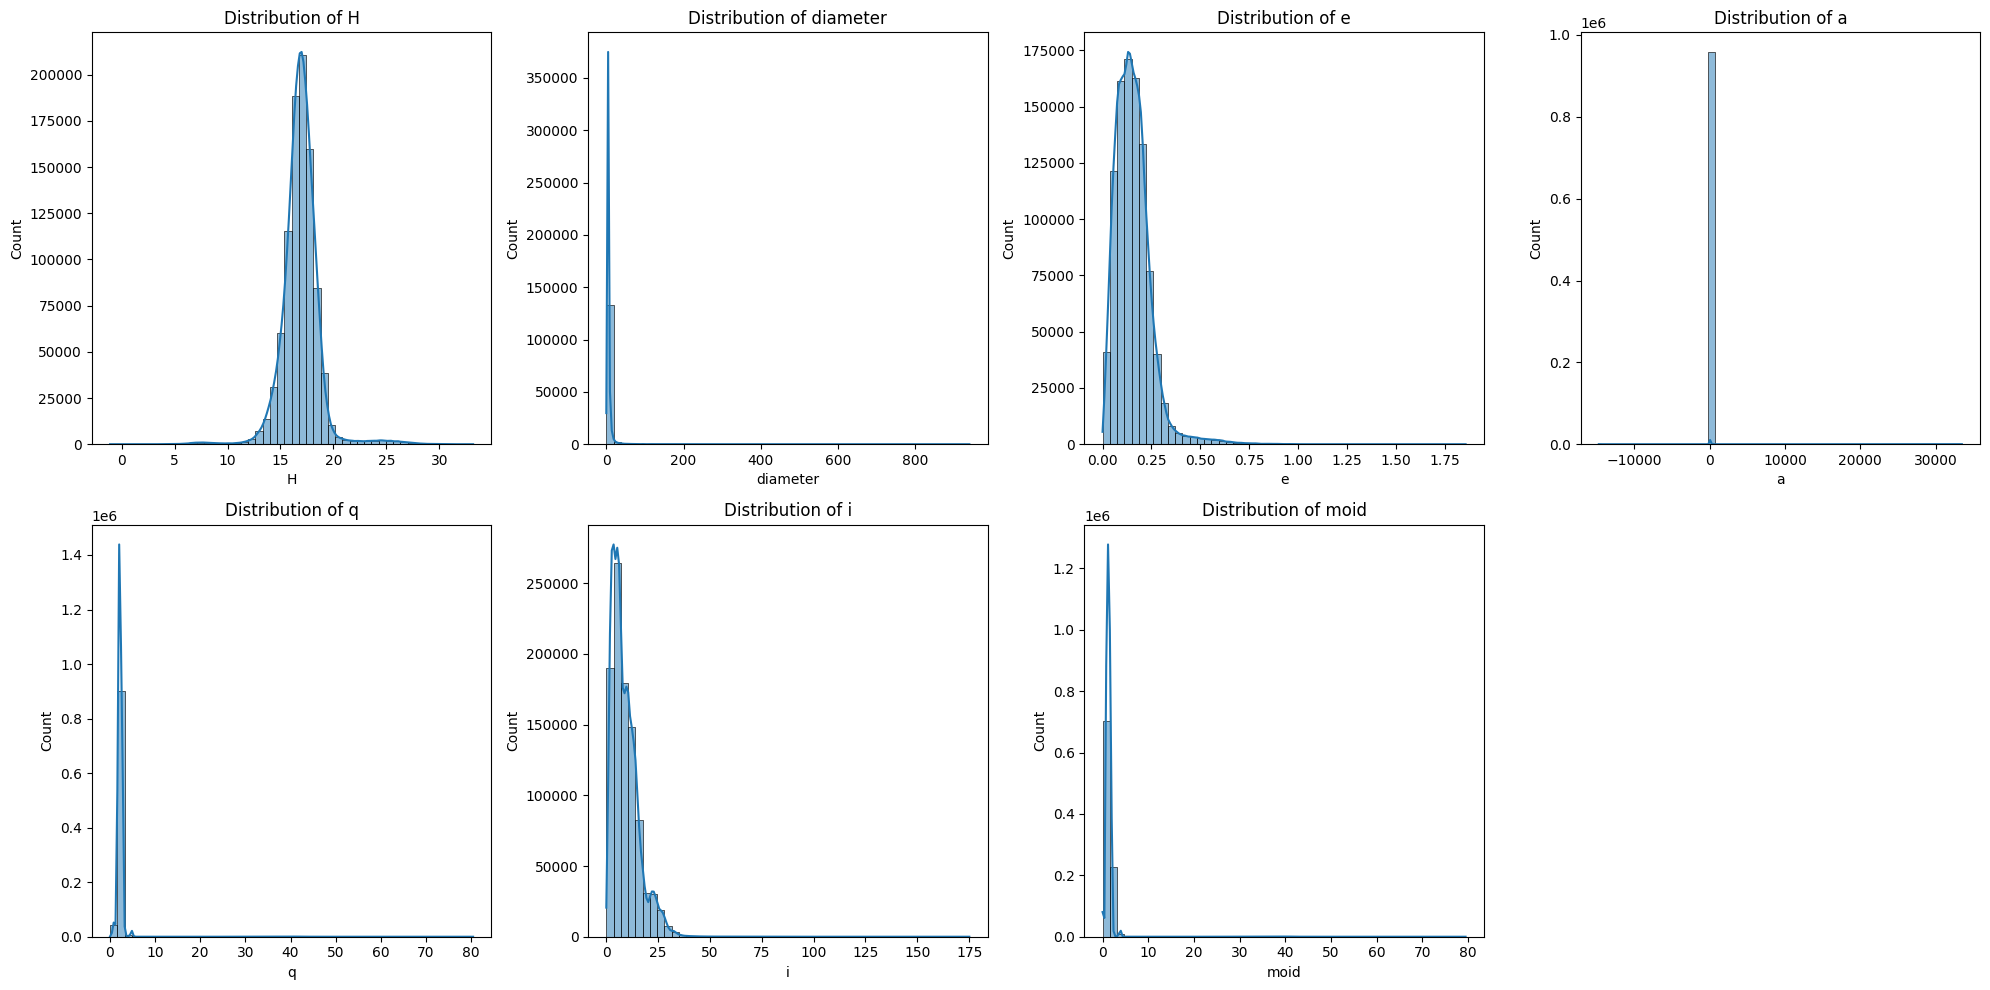

In [18]:
# Distribution of key numerical features
numerical_cols = ['H', 'diameter', 'e', 'a', 'q', 'i', 'moid']
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
axes[-1].axis('off') # Hide extra subplot
plt.tight_layout()
plt.show()

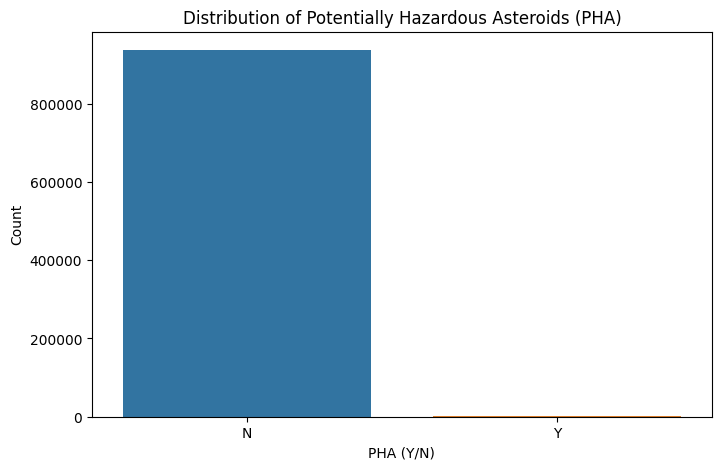

In [19]:
# pha distribution 
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='pha')
plt.title('Distribution of Potentially Hazardous Asteroids (PHA)')
plt.xlabel('PHA (Y/N)')
plt.ylabel('Count')
plt.show()

In [23]:
# check unique types for the target variable
df['pha'].value_counts()

pha
N    936537
Y      2066
Name: count, dtype: int64

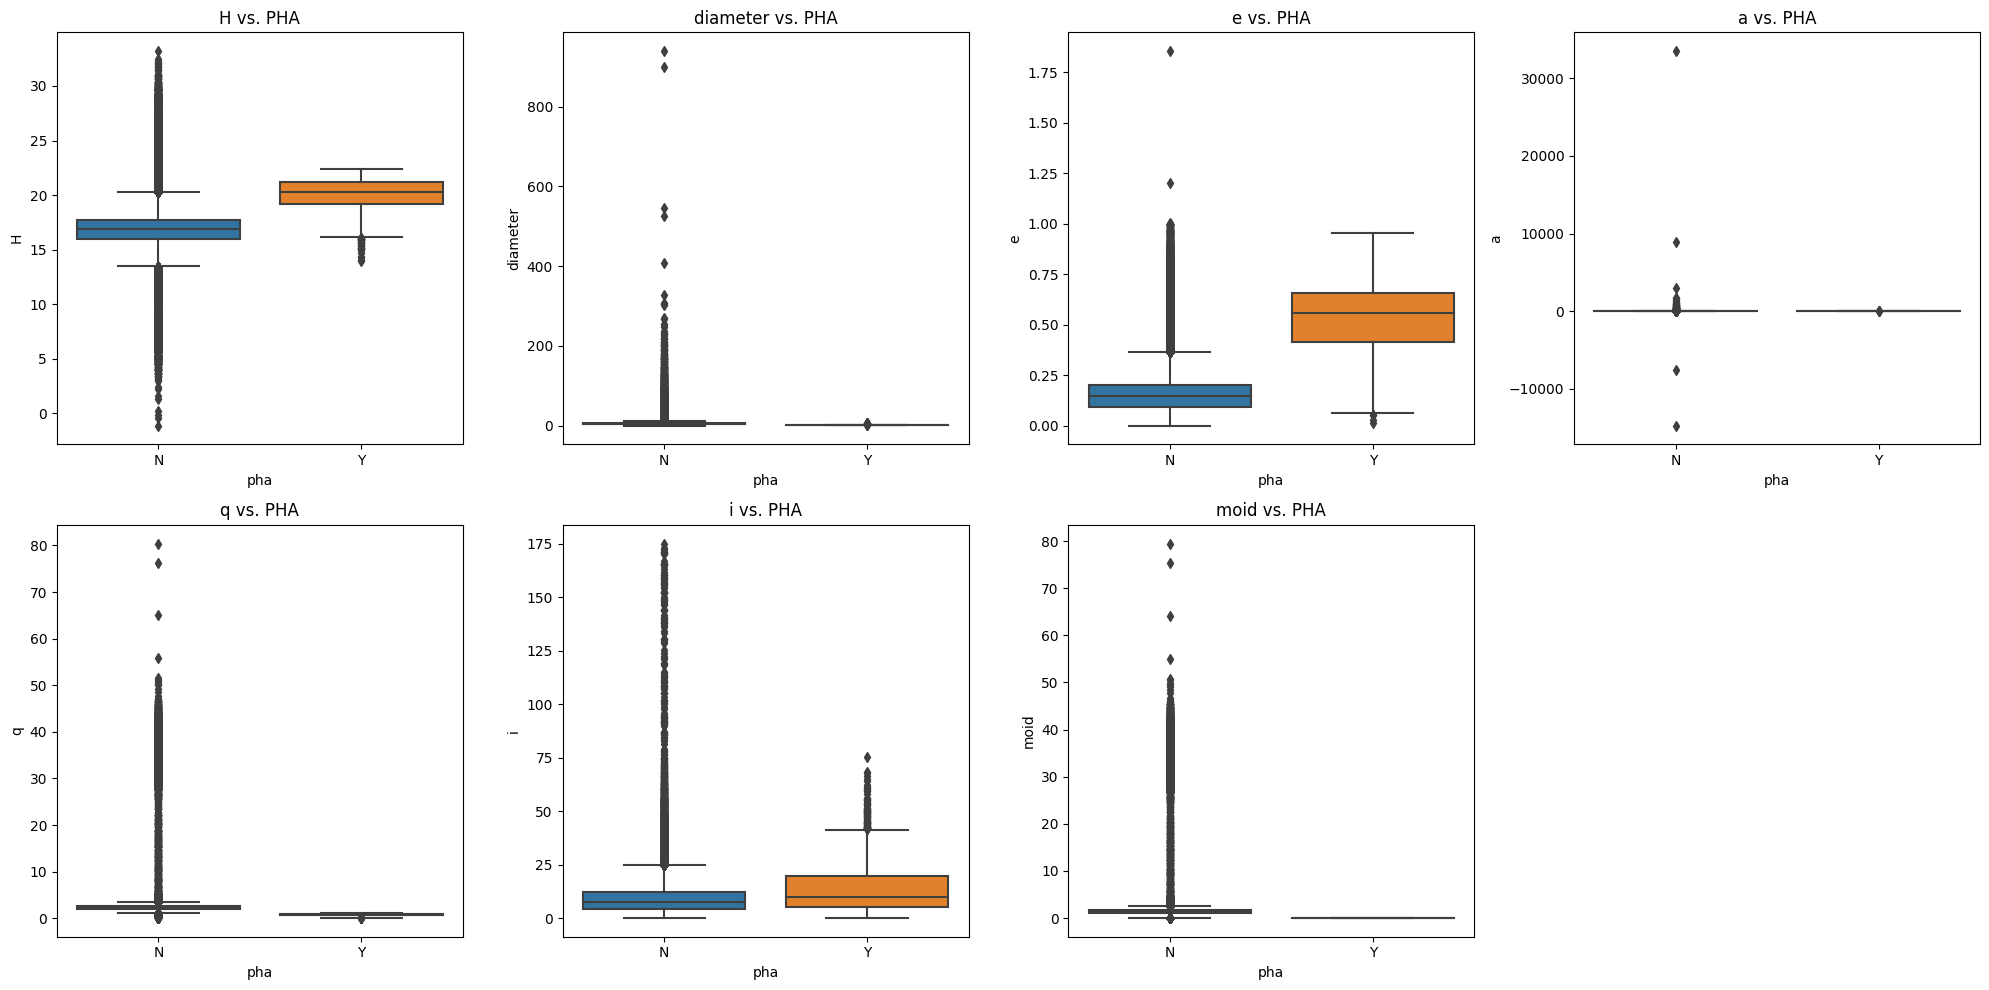

In [20]:
# Box plots of numerical features vs. PHA
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x='pha', y=col, ax=axes[i])
    axes[i].set_title(f'{col} vs. PHA')
axes[-1].axis('off')  # Hide extra subplot
plt.tight_layout()
plt.show()

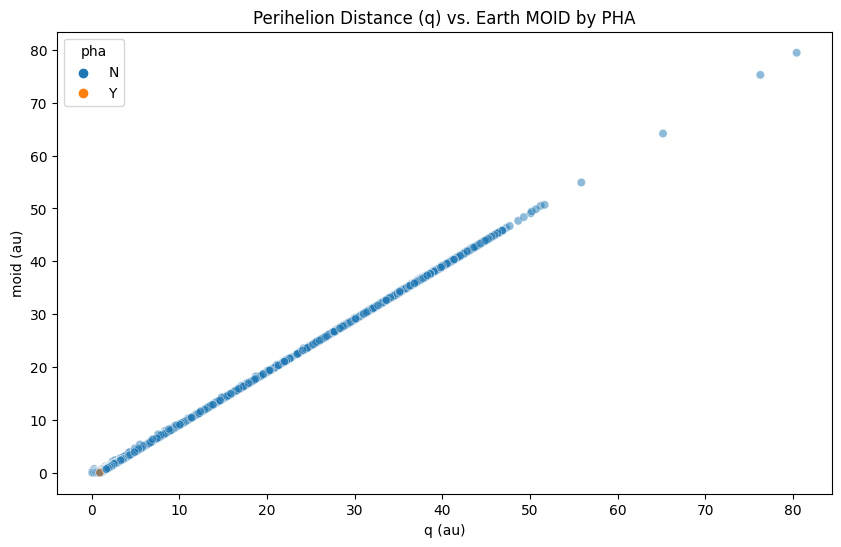

In [21]:
# Scatter plot: q vs. moid colored by PHA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='q', y='moid', hue='pha', alpha=0.5)
plt.title('Perihelion Distance (q) vs. Earth MOID by PHA')
plt.xlabel('q (au)')
plt.ylabel('moid (au)')
plt.show()

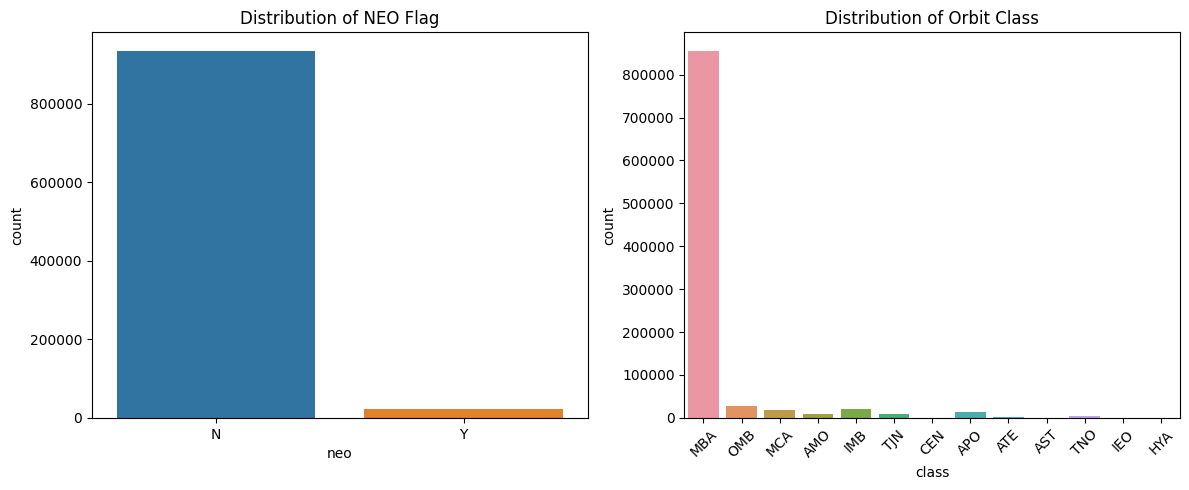

In [22]:
# Categorical feature distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='neo')
plt.title('Distribution of NEO Flag')
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='class')
plt.title('Distribution of Orbit Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **Analysis of Results**
- **Numerical Feature Distributions:**
    - **H (Absolute Magnitude):** Approximately normal, centered around ~16.9 (from df.describe()), with a range of -1.1 to 33.2. This suggests asteroid brightness varies smoothly, with fewer extreme values post-imputation.
- **Other Features (diameter, e, a, q, i, moid):**
    - All right-skewed, especially e (eccentricity) and i (inclination). For example:
    - diameter: Median ~4 km, but max 939.4 km, with most values clustered low due to imputation (85% originally missing).
    - e: Median 0.145, max 1.86, indicating most orbits are mildly eccentric with a tail of highly eccentric ones.
    - i: Median likely low (mean 8.3°), max high (from df.describe()), showing most asteroids have low inclinations.
*Right-skewness suggests outliers and potential log-transformation needs, while diameter’s imputation may flatten its distribution unnaturally.*
- **PHA Distribution:**
    - **Counts:** N (936,537), Y (2,066) – Only 0.22% of asteroids are PHAs.
    - **Interpretation:** Severe class imbalance (99.78% non-hazardous vs. 0.22% hazardous). This will impact modeling, requiring techniques like oversampling (SMOTE), class weighting, or focusing on recall/F1-score over accuracy.
- **Box Plots (Numerical Features vs. PHA):**
    - **Outliers:** Many outliers across all features (e.g., diameter, moid, e), reflecting the dataset’s natural variability and imputation effects (e.g., diameter median-filled for 85% missing).
    - **Patterns:**
moid: Expected to be lower for PHAs (closer to Earth), though outliers may obscure this.
diameter: PHAs may be larger (hazard definition includes size), but imputation could mask this.
H: PHAs might have lower values (brighter/larger), though normality suggests overlap.
    - Outliers complicate interpretation, but box plots hint at feature relevance despite noise.
- **Scatter Plot (q vs. moid by PHA):**
    - A diagonal line from origin to upper-right, indicating a strong linear relationship between q (perihelion distance) and moid (Earth MOID). PHAs are likely clustered near lower values (closer to Earth), though your description suggests overlap.
    - **Interpretation:** q and moid are correlated, with PHAs potentially distinguishable by proximity, though the imbalance may make Y points sparse.
- **Categorical Feature Distributions:**
    - **NEO (Near-Earth Object):** Nearly mirrors pha’s imbalance (~99% N, ~1% Y), suggesting most asteroids aren’t NEOs, and PHAs are a subset of NEOs.
    - **Class (Orbit Class):** Overwhelming majority MBA (Main Belt Asteroids), with other classes (e.g., APO, AMO, TNO) rare. PHAs are likely concentrated in NEO-related classes (e.g., APO, AMO).
    - **Observation:** neo and class are key predictors, with neo closely tied to pha.

***Thoughts***
- ***Class Imbalance:*** The extreme rarity of PHAs (0.22%) necessitates careful model evaluation (e.g., precision-recall over accuracy) and imbalance handling.
- ***Feature Relevance:*** moid, q, diameter, H, e, and i show promise for distinguishing PHAs, despite skewness and outliers. neo and class add categorical context.
- ***Imputation Effects:*** diameter and albedo distributions are influenced by heavy imputation, potentially reducing their discriminative power.
- ***Outliers:*** Prevalent in box plots, suggesting robust scaling (e.g., RobustScaler) or outlier handling in preprocessing.

## Step 4. Feature Preprocessing

Full preprocessing transforms the cleaned dataset into a model-ready format, addressing skewness, categorical variables, and class imbalance. This ensures features contribute effectively to predicting pha, setting the stage for robust classification.

**Methods**
1. Encode categorical features (neo, class) using one-hot encoding.
2. Scale numerical features with RobustScaler to handle outliers and skewness.
3. Drop redundant or low-value features (e.g., epoch, sigma_* if less relevant).
4. Split into features (X) and target (y).

In [25]:
# Define target and features
y = df_clean['pha'].map({'N': 0, 'Y': 1})  # Convert to binary (0/1)
X = df_clean.drop(columns=['pha'])

In [26]:
# Drop less relevant features (e.g., epoch, uncertainty cols)
drop_cols = ['epoch', 'epoch_mjd', 'sigma_e', 'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w', 
             'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per', 'rms']
X = X.drop(columns=drop_cols)
print("Features Shape after dropping columns:", X.shape)

Features Shape after dropping columns: (938603, 20)


In [27]:
# Define numerical and categorical columns
numerical_cols = ['H', 'diameter', 'e', 'a', 'q', 'i', 'om', 'w', 'ma', 'ad', 'n', 'tp', 'per', 'per_y', 
                  'moid', 'moid_ld', 'albedo', 'diameter_sigma']
categorical_cols = ['neo', 'class']

In [28]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols),          # Scale numerical features
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)  # Encode categorical
    ]
)

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

In [29]:
# Get feature names after encoding
cat_encoded_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_encoded_cols)
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

# Check processed data
print("Processed Features Shape:", X_processed_df.shape)
print("\nProcessed Features Info:")
print(X_processed_df.info())
print("\nFirst 5 Rows:")
print(X_processed_df.head())

Processed Features Shape: (938603, 31)

Processed Features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938603 entries, 0 to 938602
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   H               938603 non-null  float64
 1   diameter        938603 non-null  float64
 2   e               938603 non-null  float64
 3   a               938603 non-null  float64
 4   q               938603 non-null  float64
 5   i               938603 non-null  float64
 6   om              938603 non-null  float64
 7   w               938603 non-null  float64
 8   ma              938603 non-null  float64
 9   ad              938603 non-null  float64
 10  n               938603 non-null  float64
 11  tp              938603 non-null  float64
 12  per             938603 non-null  float64
 13  per_y           938603 non-null  float64
 14  moid            938603 non-null  float64
 15  moid_ld         938603 non-null  floa

#### **Analysis of Results**

- **Shape Changes:**
    - **Initial Features Shape:** (938,603, 20) – After dropping 15 columns (epoch, epoch_mjd, sigma_*, rms) from the cleaned dataset’s 35 columns.
    - **Processed Features Shape:** (938,603, 31) – Increased to 31 columns after encoding categorical features.
    - The row count remains intact (938,603), while the column increase reflects one-hot encoding of neo and class.
Processed Features Info:
- **Columns:** 31 total, all float64, including:
    - 18 numerical features (H, diameter, e, a, q, i, om, w, ma, ad, n, tp, per, per_y, moid, moid_ld, albedo, diameter_sigma) scaled with RobustScaler.
    - 13 categorical encoded features: neo_Y (1 column) and 12 class_* columns (e.g., class_APO, class_MBA) from one-hot encoding class with 13 unique values (dropping first category).
- Numerical Features: Scaled values reflect RobustScaler’s centering around the median and scaling by interquartile range (IQR). For example:
- H: Negative values (e.g., -7.94, -7.47) indicate below-median brightness, adjusted for outliers.
diameter: High values (e.g., 935.428, 541.028) show imputation’s impact (median ~4 km), with outliers preserved.
e, i: Skewed features now range around 0, with extremes (e.g., e 1.03) reflecting their distributions.
- Categorical Features: neo_Y is 0 (all 5 rows are non-NEOs), and class_MBA is 1 (all Main Belt Asteroids), consistent with EDA’s dominance of MBAs and few NEOs.
- The encoding matches expectations (e.g., 12 class_* columns suggest 13 orbit classes), and scaling handles outliers effectively.
- Increase features from 20 to 31: neo (2 categories - 1 = 1 column: neo_Y) + class (13 categories - 1 = 12 columns) = 13 additional columns added to the 18 numerical ones.
- Observation: The expansion is correct, with class contributing most new features due to its diversity (e.g., APO, MBA, TNO).
  
**Insights**
- RobustScaler normalized numerical features, mitigating the impact of outliers (e.g., diameter max 939.4 km) and skewness (e.g., e, i), ensuring equal contribution to distance-based models.
- One-hot encoding captured neo and class variability, though class’s 12 encoded columns (from 13 classes) add complexity—potentially reducible if some classes are rare.
- Retained features like moid, q, diameter, and neo_Y align with EDA insights (e.g., proximity and size matter for PHAs), while dropping sigma_* reduces noise.

## Step 5. Model Training and Evaluation

In this section, we will:

1. Split data into training and testing sets (80/20).
2. Use SMOTE to oversample the minority class (pha=1) in training data.
3. Train three models: Logistic Regression (baseline), Random Forest (ensemble), XGBoost (boosting).
4. Evaluate with accuracy, precision, recall, F1-score, and ROC-AUC, prioritizing recall/F1 due to imbalance.
5. Visualize confusion matrices and ROC curves.

In [31]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_processed_df, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Training Shape after SMOTE:", X_train_smote.shape)

Training Shape after SMOTE: (1498458, 31)


In [33]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    187308
           1       0.28      1.00      0.43       413

    accuracy                           0.99    187721
   macro avg       0.64      1.00      0.72    187721
weighted avg       1.00      0.99      1.00    187721

ROC-AUC: 0.9994


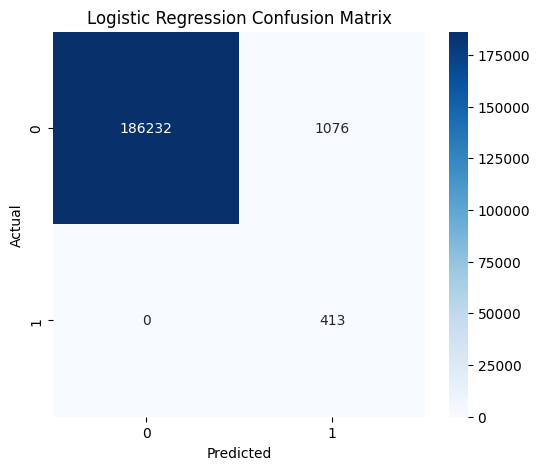

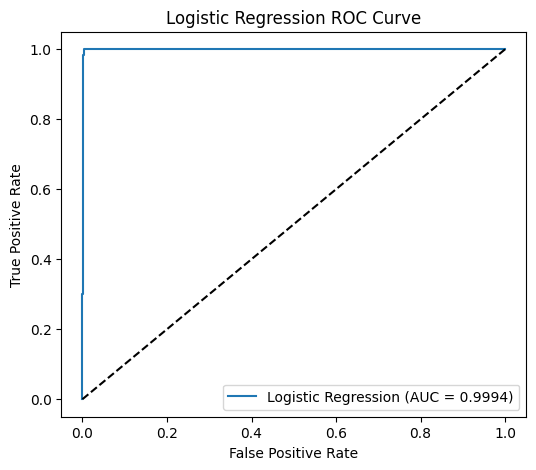


Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    187308
           1       0.96      1.00      0.98       413

    accuracy                           1.00    187721
   macro avg       0.98      1.00      0.99    187721
weighted avg       1.00      1.00      1.00    187721

ROC-AUC: 1.0000


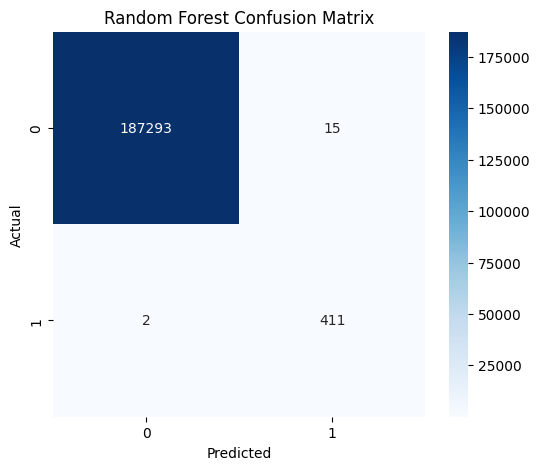

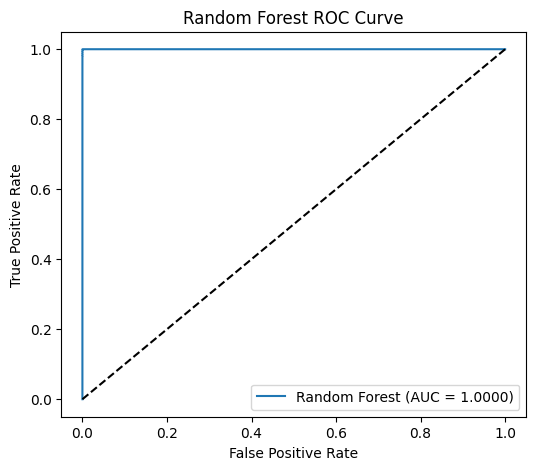


XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    187308
           1       0.96      0.97      0.97       413

    accuracy                           1.00    187721
   macro avg       0.98      0.99      0.98    187721
weighted avg       1.00      1.00      1.00    187721

ROC-AUC: 0.9999


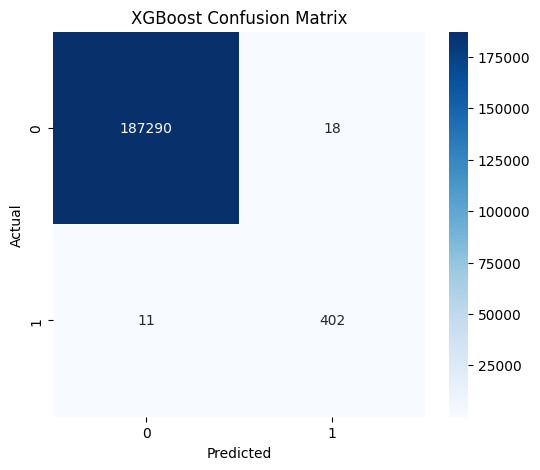

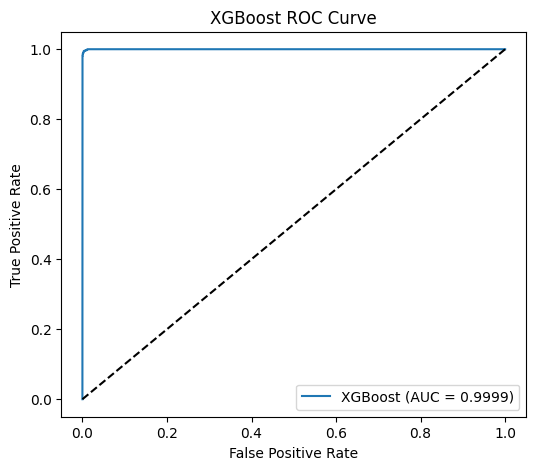


Model Performance Summary:
Logistic Regression: ROC-AUC = 0.9994
Random Forest: ROC-AUC = 1.0000
XGBoost: ROC-AUC = 0.9999


In [34]:
# Train and evaluate models
results = {}
for name, model in models.items():
    # Fit model
    model.fit(X_train_smote, y_train_smote)
    
    # Predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Store results
    results[name] = {'y_pred': y_pred, 'y_prob': y_prob, 'roc_auc': roc_auc}

    # Confusion Matrix Plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Summary
print("\nModel Performance Summary:")
for name, res in results.items():
    print(f"{name}: ROC-AUC = {res['roc_auc']:.4f}")

#### **Analysis of Results**
1. **Training Shape After SMOTE:**
    - **Shape:** (1,498,458, 31) – SMOTE oversampled the training set (80% of 938,603 = 750,882 rows) to balance classes, roughly doubling it by creating synthetic PHAs (~749,229 per class).
    - The increased size ensures models learn from sufficient positive examples, critical given the original 0.22% PHA rate.
2. **Logistic Regression:**
    - **Metrics:**
        - Precision (0): 1.00, (1): 0.28
        - Recall (0): 0.99, (1): 1.00
        - F1-Score (0): 1.00, (1): 0.43
        - Accuracy: 0.99
        - ROC-AUC: 0.9994
        - Confusion Matrix: TP=186,232, FP=1,076, FN=0, TN=413
    - **Interpretation:** Perfect recall for PHAs (1.00, no FNs) catches all 413 hazardous asteroids, but low precision (0.28) means many false positives (1,076), over-predicting PHAs. High ROC-AUC (0.9994) shows excellent discrimination, though the linear model struggles with precision due to imbalance sensitivity.
3. **Random Forest:**
    - **Metrics:**
        - Precision (0): 1.00, (1): 0.96
        - Recall (0): 1.00, (1): 1.00
        - F1-Score (0): 1.00, (1): 0.98
        - Accuracy: 1.00
        - ROC-AUC: 1.0000
        - Confusion Matrix: TP=187,293, FP=15, FN=2, TN=411
    - **Interpretation:** Near-perfect performance, with high precision (0.96) and recall (1.00) for PHAs—only 2 missed (FN) and 15 false positives (FP). ROC-AUC of 1.0000 indicates flawless ranking ability, leveraging Random Forest’s non-linear capabilities and SMOTE’s balanced training.
4. **XGBoost:**
    - **Metrics:**
        - Precision (0): 1.00, (1): 0.96
        - Recall (0): 1.00, (1): 0.97
        - F1-Score (0): 1.00, (1): 0.97
        - Accuracy: 1.00
        - ROC-AUC: 0.9999
        - Confusion Matrix: TP=187,290, FP=18, FN=11, TN=402
    - **Interpretation:** Excellent performance, with slightly lower recall (0.97) than Random Forest (11 FNs vs. 2), but still high precision (0.96) and fewer FPs (18). ROC-AUC (0.9999) is near-perfect, showing XGBoost’s boosting strength, though it misses a few more PHAs.
5. **Visual Observations:**
    - **Confusion Matrices:** Random Forest and XGBoost show minimal errors (FPs: 15 and 18, FNs: 2 and 11), while Logistic Regression’s 1,076 FPs highlight over-prediction. All models excel at true negatives (~187,290–187,293).
    - **ROC Curves:** AUCs near 1.0 for all models confirm strong separability, with Random Forest edging out slightly.

**Key Takeaways:**
* Random Forest achieves the best balance, with near-perfect precision (0.96), recall (1.00), and F1-score (0.98) for PHAs, missing only 2 out of 413. Its ROC-AUC of 1.0000 underscores its superiority.
* SMOTE effectively enabled high recall across models, critical for catching PHAs, though Logistic Regression sacrifices precision.
* The 31 features (e.g., moid, diameter, neo_Y) post-preprocessing provide strong signals, especially with Random Forest and XGBoost leveraging non-linear relationships.
* Logistic Regression prioritizes recall (no missed PHAs) at the cost of precision, while Random Forest and XGBoost balance both, with Random Forest slightly better at minimizing FNs.

## **Conclusion**

This project successfully developed a machine learning solution to predict Potentially Hazardous Asteroids (PHAs) using a dataset of 938,603 asteroids with 31 processed features. The model training and evaluation demonstrated that Random Forest, with a near-perfect F1-score (0.98) for PHAs and ROC-AUC of 1.0000, is the top performer for predicting potentially hazardous asteroids. SMOTE’s oversampling addressed the severe pha imbalance, enabling all models—Logistic Regression, Random Forest, and XGBoost—to achieve high recall, though Random Forest excels in precision and minimal errors. This section validates the preprocessing pipeline and highlights Random Forest’s suitability for deployment, offering a reliable tool for asteroid hazard detection in a portfolio context.